# Let's make a kinematic cyclone in shear for SKEdot elucidation
## Straight shear + deep Rankine vortex, optionally with zero-$\zeta_{abs}$ anticyclone on top 
## + w field based on making vortex "resilient" (downshear ascent)
### (stretching term devised to oppose $\zeta$ tendencies due to advection by shearflow)

In [1]:
import xarray as xr
import numpy as np
import G5NR_utils

In [2]:
%reload_ext ipython_IDV

# Make the array shape match G5NR case studies

In [86]:
path = '/Users/bem/Jupyter/G5NR_Interactive_notebooks/'
zbundlefile = path+'data/ZIDV_cases/skedot_40.1_prec_119.7_lat_28.6_lon_148.0_time_200610131230.zidv'
xrdata_3d = xr.from_zidv(zbundlefile)

In [87]:
# Why the $&#(@#* are there NANs here? 
print( xrdata_3d.u[0,70,:,128] )

<xarray.DataArray 'u' (lat: 176)>
array([ 13.246612,  13.465362,  13.590362,  13.699737,  14.121612,  14.652862,
        14.840362,  14.840362,  15.090362,  15.559112,  15.996612,  16.309113,
        16.434113,  16.465363,  16.559113,  16.652863,  16.809113,  17.059113,
        17.465363,  17.934113,  18.340363,        nan,  18.652863,  18.902863,
        19.246613,  19.652863,  20.121613,  20.715363,  21.371613,  21.902863,
        22.465363,  23.215363,  23.902863,  24.434113,  25.027863,  25.871613,
        26.902863,  28.090363,  29.340363,  30.496613,  31.277863,  31.965363,
        32.715363,  33.715363,  34.652863,  35.215363,  36.027863,  37.215363,
        38.402863,  39.527863,  40.777863,  42.527863,  44.652863,  46.840363,
        49.027863,  51.215363,  51.902863,  49.215363,  42.402863,  32.152863,
        21.027863,  14.090362,  11.840362,  10.215362,   8.105987,   5.879424,
         3.434112,   0.574737,  -2.526826,  -6.737763, -12.644013, -20.034637,
       -29.409637,

In [88]:
xrdata_3d = xr.open_dataset('data/data_0_3D7km30minuteInst.nc')
print( xrdata_3d.u[0,70,:,128] )

<xarray.DataArray 'u' (lat: 173)>
array([ 13.152862,  13.340362,  13.527862,  13.684112,  13.965362,  14.449737,
        14.809112,  14.809112,  14.871612,  15.152862,  15.590362,  16.027863,
        16.371613,  16.434113,  16.465363,  16.590363,  16.746613,  16.934113,
        17.215363,  17.590363,  18.059113,  18.496613,  18.809113,  19.121613,
        19.465363,  19.934113,  20.465363,  21.027863,  21.652863,  22.309113,
        23.027863,  23.746613,  24.402863,  24.996613,  25.715363,  26.715363,
        27.902863,  29.246613,  30.559113,  31.465363,  31.840363,  32.152863,
        32.652863,  33.340363,  33.840363,  34.340363,  35.215363,  36.277863,
        37.402863,  38.527863,  39.840363,  41.652863,  43.902863,  46.027863,
        47.965363,  49.027863,  46.965363,  40.777863,  31.590363,  21.965363,
        15.590362,  13.090362,  11.043487,   8.355987,   5.090362,   1.555206,
        -2.36081 ,  -6.409638, -11.300263, -17.753387, -25.784637, -35.347137,
       -44.597137,

In [89]:
arrays = xrdata_3d  #.isel(time=(0,1)) 
arrays

<xarray.Dataset>
Dimensions:  (lat: 173, lev: 72, lon: 241, time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2006-10-13T11:30:00 2006-10-13T12:00:00 ...
  * lev      (lev) float64 0.01 0.02 0.0327 0.0476 0.066 0.0893 0.1197 ...
  * lat      (lat) float64 23.25 23.31 23.38 23.44 23.5 23.56 23.62 23.69 ...
  * lon      (lon) float64 140.5 140.6 140.6 140.7 140.8 140.8 140.9 140.9 ...
Data variables:
    u        (time, lev, lat, lon) float32 ...
    v        (time, lev, lat, lon) float32 ...
    w        (time, lev, lat, lon) float32 ...
    airdens  (time, lev, lat, lon) float32 ...
Attributes:
    title:                3d,30-Minute,Instantaneous,Model-Level,Full Resolut...
    Conventions:          CF-1.0
    dataType:             Grid
    history:              Thu Dec 08 16:06:15 EST 2016 : imported by GrADS Da...
    extra_das_attribute:  This is an example of metadata added using a supple...
    History:              Translated to CF-1.0 Conventions by Netcdf-Java CDM...
   

# Shear flow: linear in pressure, zero at 500 hPa 

In [90]:
ushear = arrays.u.copy()*0 + 10*(arrays.lev - 500.)/500.
vshear = arrays.v.copy()*0 

# Vortex: (vtan $\alpha$ $r^{-1}$), except  (vtan $\alpha$ $r$) near center

In [94]:
centerlat = arrays.lat.mean().values
centerlon = arrays.lon.mean().values

lon2d, lat2d = np.meshgrid(arrays.lon, arrays.lat)

# radius in degrees from center
r = np.sqrt( (lat2d-centerlat)**2 + (lon2d-centerlon)**2 )
az = np.arctan2((lat2d-centerlat), (lon2d-centerlon))

# vtan of 10 m/s at 1 degree, zero vorticity far field
vtan = 10.0/(r + 1e-6) # avoid division by zero; it will be overwritten in core anyway
# rankine near center
inner = np.where(r<1)
vtan[inner] = 10.0*r[inner]

vvortex =  vtan * np.cos(az)
uvortex = -vtan * np.sin(az)

# Broadcast vortex to all levels with p > 200 hPa

In [95]:
ushearvort = ushear.copy()  # right shaped array
vshearvort = vshear.copy()

troposphere = np.where(arrays.lev > 200)
print(troposphere)

for i in troposphere:
    ushearvort[:,i,:,:] += uvortex
    vshearvort[:,i,:,:] += vvortex

(array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]),)


# Define a w field
## radial shape from vtan, wave1 in azimuth, sin(p) in lev

In [97]:
wshearvort = 0*ushearvort.copy() # right shaped array

left_of_downshear = np.pi/180.* 0 # angle offset of updraft from downshear direction

sinprofile = np.sin(np.pi * (arrays.lev - 200)/800.)

for i in troposphere:
    wshearvort[:,i,:,:] = vtan * np.cos(az - left_of_downshear)  /100. # max of 0.1 m/a
    wshearvort[:,i,:,:] *= sinprofile[i]

# Put the synthetic data back into the xarray dataset and export


In [98]:
arrays.u.values = ushearvort
arrays.v.values = vshearvort
arrays.w.values = wshearvort

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/drilsdown/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['inner']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


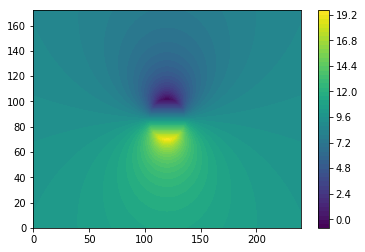

In [100]:
%pylab inline
#contourf(uvortex, 50); colorbar()
contourf(ushearvort[0,70,:,:], 50); colorbar()

In [101]:
arrays.to_IDV()

data loaded


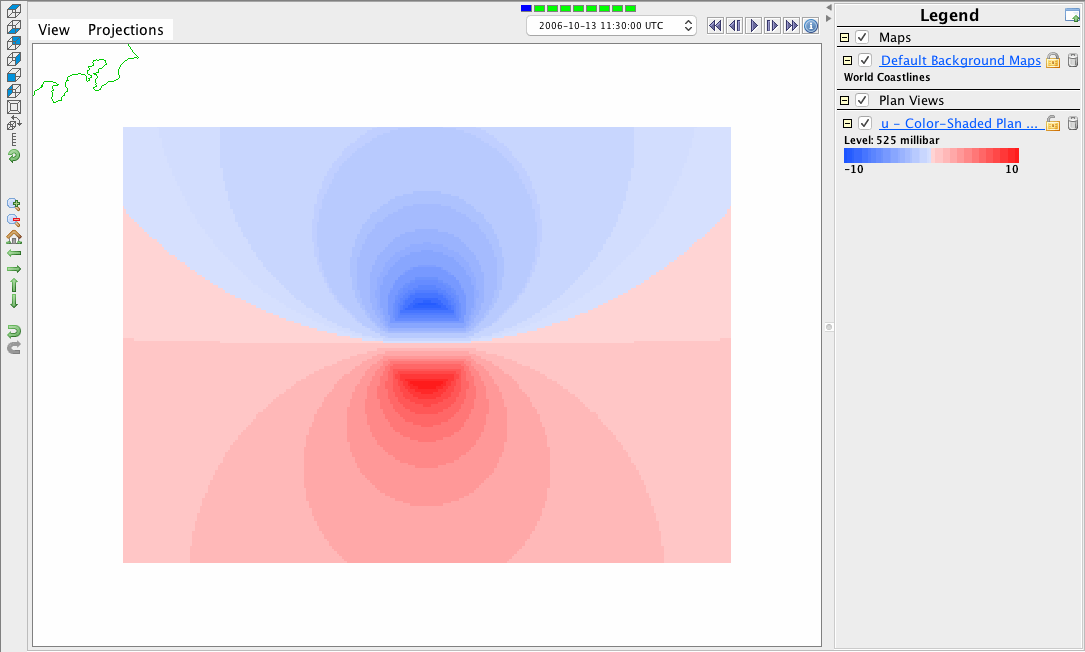

In [102]:
%make_image -capture legend

In [104]:
arrays.to_netcdf(path + 'data/synth_vortex_in_shear.nc')